In [1]:
import numpy as np
import pandas as pd
import fdringdown as rd
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde

from plot_utils import rcparams, c_t0_prior, conversion, t_ref, Mf_det, gaussian
plt.rcParams.update(rcparams)

In [2]:
t0_choices = np.arange(-10, 26, 5)

# Normal
run_dict_normal = {
    '1W220': [16, 17, 18, 19, 20, 21, 22, 23],
    '1W220221': [21, 22, 23, 24, 25, 26, 27, 28],
    '1W220330': [31, 16, 17, 18, 19, 20, 21, 22],
    }

In [3]:
run_dict = run_dict_normal
run_type = '1W220221'

In [4]:
event = rd.GWevent('GW190521')
ref_IFO = rd.interferometer('L1')

Loading file H-H1_GWOSC_4KHZ_R1-1242440920-4096.hdf5
Loading file L-L1_GWOSC_4KHZ_R1-1242440920-4096.hdf5
Loading file V-V1_GWOSC_4KHZ_R1-1242440920-4096.hdf5


In [5]:
t0_posteriors = {}

for i, run_number in enumerate(run_dict[run_type]):

    posterior = pd.read_csv(
        f'../../runs/GW190521/{run_type}/{run_number:02d}/posterior_samples.dat'
        ).sample(n=10000)

    # Geocenter start time
    start_time_posterior = np.array(posterior.t_0)

    # Transform each time sample to the desired frame by calculating the
    # time delay (with the corresponding sky posterior sample)
    for j, (index, sample) in enumerate(posterior.iterrows()):

        # Extract sky location params
        ra = sample.ra
        dec = sample.dec
        t_event = sample.t_event

        time_delay = ref_IFO.time_delay([0,0,0], ra, dec, t_event)
        start_time_posterior[j] += time_delay - t_ref
        
    t0_posteriors[i] = start_time_posterior

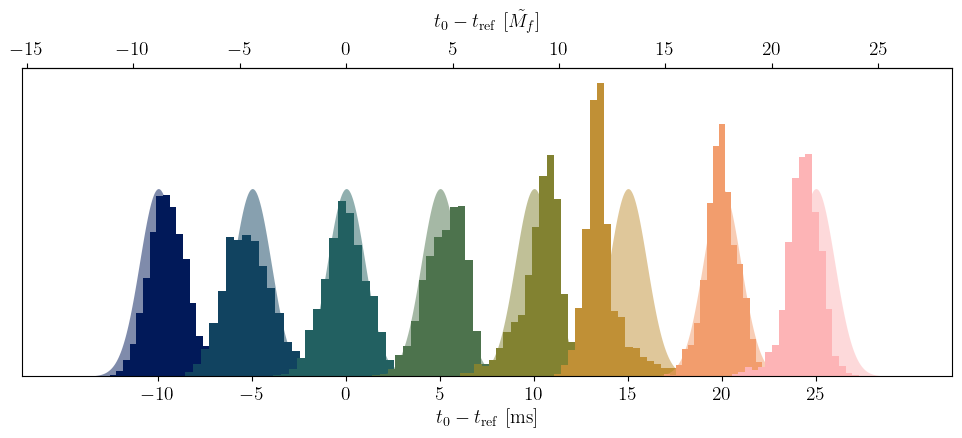

In [6]:
fig, ax = plt.subplots(figsize=(12,4))

for i, t0_posterior in t0_posteriors.items():
    
    ax.hist(t0_posterior*1000, bins=20, density=True, color=c_t0_prior[i])
    
    x = np.linspace(-15, 30, 1000)
    ax.fill_between(x, gaussian(x, mu=t0_choices[i]), color=c_t0_prior[i], alpha=0.5, lw=0)

ax.set_xlabel(r'$t_0 - t_\mathrm{ref}\ [\mathrm{ms}]$')

ax.set_xticks(t0_choices)

ax.set_yticks([])
    
# Secondary axis
def M_to_ms(x):
    return (x*conversion)*1000
def ms_to_M(x):
    return (x/conversion)/1000

secax = ax.secondary_xaxis('top', functions=(ms_to_M, M_to_ms))
_ = secax.set_xlabel(r'$t_0 - t_\mathrm{ref}\ [\tilde{M_f}]$', labelpad=10)

fig.savefig('start_time_overtone.png', dpi=360, bbox_inches='tight')